### Evaluation

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt


In [82]:
df = pd.read_csv('../3-classification/course_lead_scoring.csv')

### Fill NAs

In [83]:
for col in ['lead_source', 'industry', 'employment_status', 'location']:
    df[col] = df[col].fillna('NA') 

for col in ['annual_income']:
    df[col] = df[col].fillna(0.0)

In [106]:
# Split FIRST
df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=1)

# THEN handle missing values on each split
for split_df in [df_train, df_val, df_test]:
    for col in ['lead_source', 'industry', 'employment_status', 'location']:
        split_df[col] = split_df[col].fillna('NA')
    for col in ['annual_income']:
        split_df[col] = split_df[col].fillna(0.0)

X_train = df_train.drop('converted', axis=1)
y_train = df_train['converted'].values

X_val = df_val.drop('converted', axis=1) 
y_val = df_val['converted'].values

X_test = df_test.drop('converted', axis=1)
y_test = df_test['converted'].values

### ROC AUC

In [107]:
auc_score_dict = {}
for col in ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']:
    if roc_auc_score(y_train, X_train[col]) < 0.5:
        auc_score_dict[col] = roc_auc_score(y_train, -X_train[col])
    else:
        auc_score_dict[col] = roc_auc_score(y_train, X_train[col])
    

In [108]:
sorted(auc_score_dict.items(), key= lambda item: item[1])

[('annual_income', 0.5519578313253012),
 ('lead_score', 0.6144993577250176),
 ('interaction_count', 0.738270176293409),
 ('number_of_courses_viewed', 0.7635680590007088)]

### Logistic Regression Model

In [200]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

def df_to_dicts(X):
    return X.to_dict(orient='records')

# Create pipeline with DictVectorizer
log_reg_pipe = Pipeline([
    ('to_dict', FunctionTransformer(df_to_dicts, validate=False)),
    ('dict_vectorizer', DictVectorizer(sparse=False)),
    ('standard_scaler', StandardScaler()),
    ('log_reg', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000))
])

In [133]:
log_model = log_reg_pipe.fit(X_train, y_train)

In [134]:
y_pred = log_model.predict_proba(X_val)[:, 1]

In [135]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, y_pred)

0.9210046975361903

### Precision and Recall

In [163]:
thresholds = np.arange(0.0, 1.0, 0.001)

In [164]:
def calculate_tpr_fpr(y_val, y_pred, thresholds) -> List[Tuple]:
    scores = []
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    return scores

In [165]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(calculate_tpr_fpr(y_val, y_pred, thresholds), columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

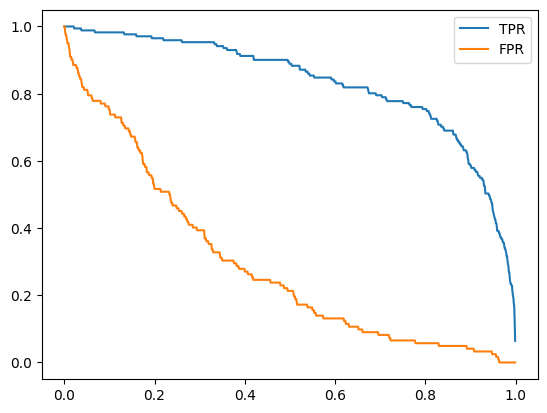

In [166]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

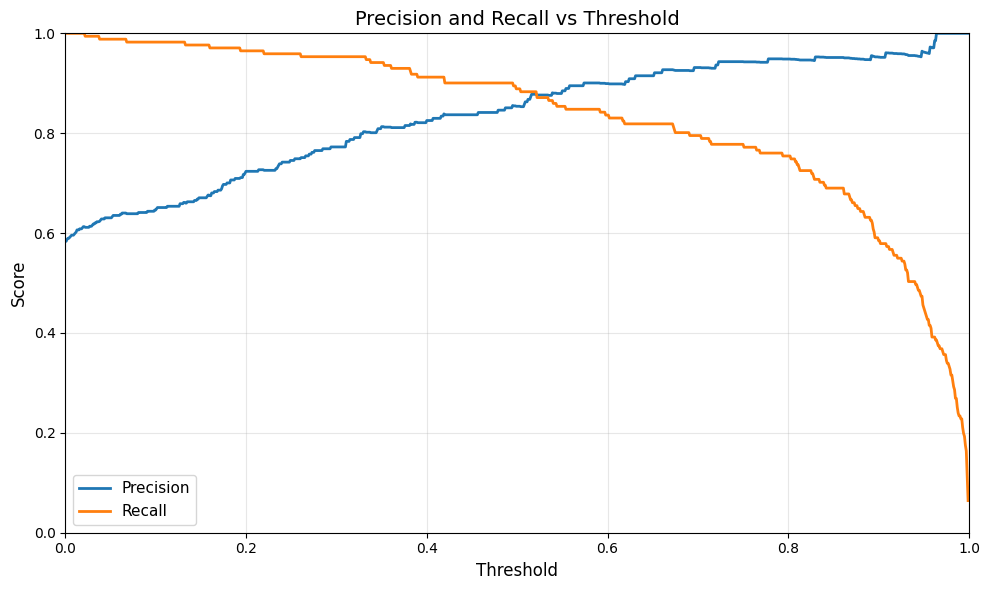

In [167]:
# Add precision and recall to your dataframe
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

# Handle division by zero (when tp + fp = 0)
df_scores['precision'] = df_scores['precision'].fillna(0)
df_scores['recall'] = df_scores['recall'].fillna(0)

# Plot precision and recall
plt.figure(figsize=(10, 6))
plt.plot(df_scores.threshold, df_scores.precision, label='Precision', linewidth=2)
plt.plot(df_scores.threshold, df_scores.recall, label='Recall', linewidth=2)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Precision and Recall vs Threshold', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

df_scores['diff'] = np.abs(df_scores.precision - df_scores.recall)
intersection_row = df_scores.loc[df_scores['diff'].idxmin()]

### F1 Score

In [169]:
df_scores['f1_score'] = df_scores.apply(lambda x: 2 * (x['precision'] * x['recall']) / (x['precision'] + x['recall']), axis = 1)

In [175]:
df_scores.iloc[df_scores['f1_score'].idxmax(), :]['threshold']

np.float64(0.516)

### 5-fold CV

In [180]:
from sklearn.model_selection import KFold

In [ ]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)




In [201]:
k_fold_scores = []

cv = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in cv.split(df_full_train):
    y_train = df_full_train.iloc[train_idx].converted.values
    y_val = df_full_train.iloc[val_idx].converted.values

    X_train = df_full_train.iloc[train_idx].drop('converted', axis=1).reset_index(drop=True) 
    X_val = df_full_train.iloc[val_idx].drop('converted', axis=1).reset_index(drop=True) 

    
    log_reg_pipe.fit(X_train, y_train)

    y_pred = log_reg_pipe.predict_proba(X_val)[:, 1]

    k_fold_scores.append(roc_auc_score(y_val, y_pred))

    
    

In [202]:
np.std(k_fold_scores, ddof=1)

np.float64(0.011661808922263104)

### Hyperparameter Tuning

In [207]:
c_val_hyp_tuning = {}

for c_val in [0.000001, 0.001, 1]:
    k_fold_scores = []
    
    cv = KFold(n_splits=5, shuffle=True, random_state=1)

    log_reg_pipe = Pipeline([
    ('to_dict', FunctionTransformer(df_to_dicts, validate=False)),
    ('dict_vectorizer', DictVectorizer(sparse=False)),
   # ('standard_scaler', StandardScaler()),
    ('log_reg', LogisticRegression(solver='liblinear', C=c_val, max_iter=1000))
    ])

    for train_idx, val_idx in cv.split(df_full_train):
        y_train = df_full_train.iloc[train_idx].converted.values
        y_val = df_full_train.iloc[val_idx].converted.values

        X_train = df_full_train.iloc[train_idx].drop('converted', axis=1).reset_index(drop=True) 
        X_val = df_full_train.iloc[val_idx].drop('converted', axis=1).reset_index(drop=True) 

        
        log_reg_pipe.fit(X_train, y_train)

        y_pred = log_reg_pipe.predict_proba(X_val)[:, 1]

        k_fold_scores.append(roc_auc_score(y_val, y_pred))
    
    c_val_hyp_tuning[c_val] = [round(np.mean(k_fold_scores),3) , np.std(k_fold_scores)]


In [212]:
sorted(c_val_hyp_tuning.items(), key=lambda x: x[1][0], reverse=True )[0]

(0.001, [np.float64(0.867), np.float64(0.028746230508215103)])